# Imports

In [1]:
import jax
import jax.numpy as jnp 
from jax import vmap, grad, jit
import optax
from sample_trajectory import *
from utils import *
import numpy as np
import matplotlib.pyplot as plt
from jax.typing import ArrayLike
from typing import Callable
from tqdm import tqdm

# Globals

In [130]:
horizon = 100
n_trajectories = 1000
minibatch_size = 1000
rep_dim = 16 
tau_fixation = 0.5
tau_saccade = 0.9
n_actions = 3 

# Sampling trajectories

In [3]:
# Generate Trajectories
init_key = jax.random.PRNGKey(0)
batch_keys = jax.random.split(init_key, n_trajectories)
trajectories, goals = vmap(jit(lambda k: generate_trajectory(key=k, horizon=horizon)))(batch_keys)
angles, velocities, times = trajectories
angles.shape, velocities.shape, times.shape # batch_dim, horizon

((1000, 100), (1000, 100), (1000, 100))

In [4]:
# Converting velocities into actions 
actions = (np.sign(velocities) - 3) / -2
actions[velocities == 0.0] = 0
actions = jnp.asarray(actions, dtype=int)

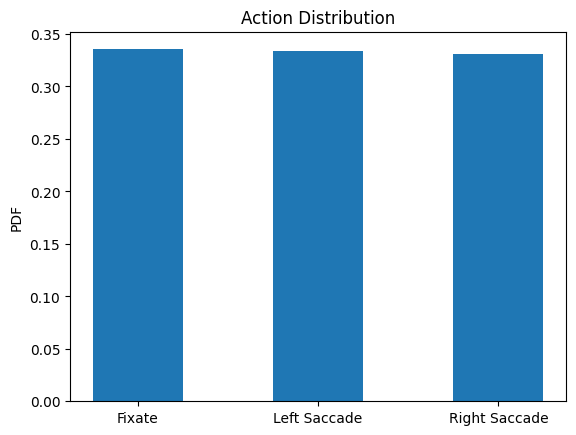

In [6]:
plt.hist(actions.flatten(), bins=np.linspace(0,3,4), density=True, rwidth=0.5)
plt.title("Action Distribution")
plt.xticks([0.5, 1.5, 2.5], ['Fixate', 'Left Saccade', 'Right Saccade'])
plt.ylabel("PDF");

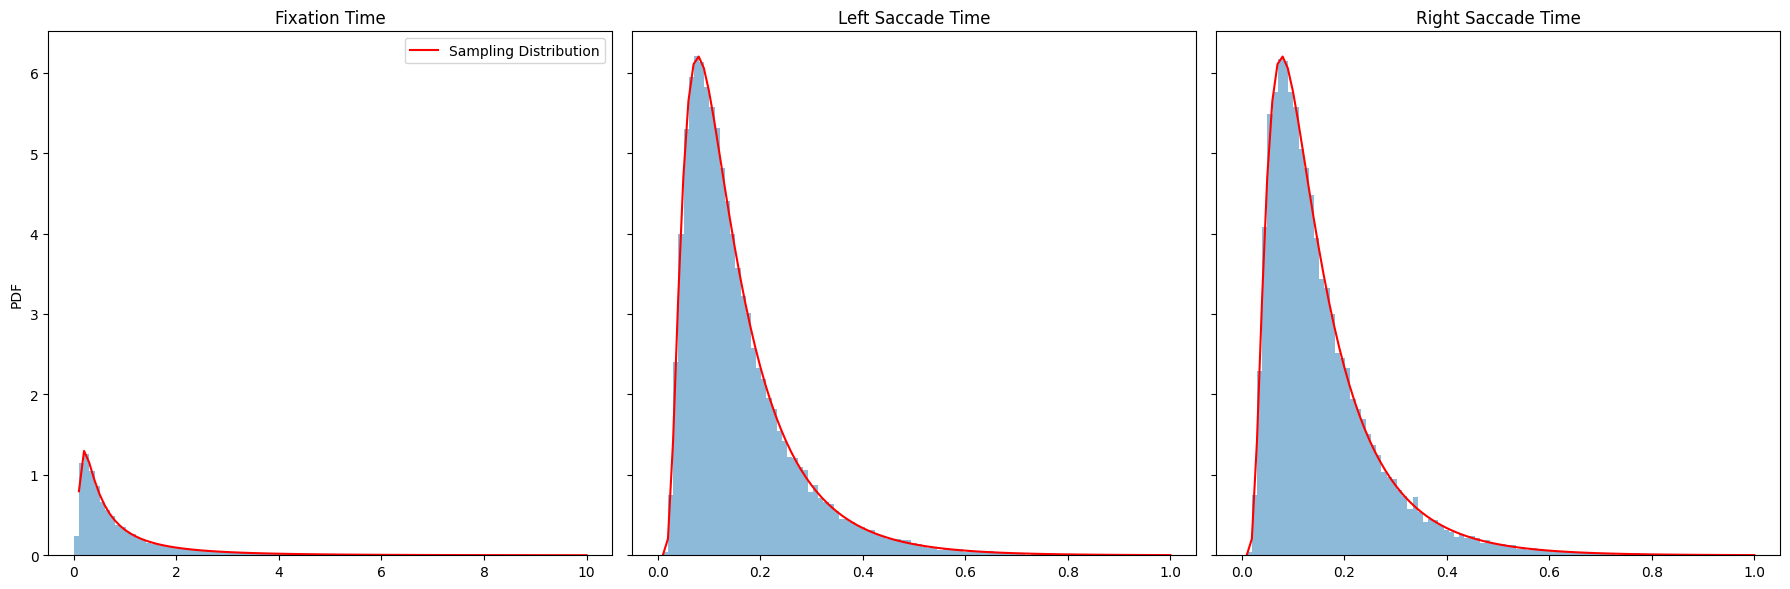

In [7]:
# Time for all actions
def ig_dist(x, mu, con):
    return (con / (2 * np.pi * x**3))**(0.5) * np.exp(-con * (x - mu)**2 / (2 * mu**2 * x))
# Get average saccade velocity param for ig dist 
mean_saccade_intensity = jnp.abs(velocities.flatten()[actions.flatten() != 0]).mean()
mean_saccade_vel_param = 0.56 / (2.33 * jax.nn.sigmoid(7.55 * (mean_saccade_intensity - 0.35)) - -1.26)
fig, axs = plt.subplots(1, 3, tight_layout=True, figsize=(18,6), sharey=True)
axs[0].hist(times.flatten()[actions.flatten() == 0], bins=np.linspace(0, 10, 100), density=True, alpha=0.5)
axs[0].plot(np.linspace(0.1, 10, 100), ig_dist(np.linspace(0.1, 10, 100), 1.0, 0.79**2), color='r', label="Sampling Distribution")
axs[0].legend()
axs[0].set_title('Fixation Time')
axs[0].set_ylabel('PDF')
axs[1].hist(times.flatten()[actions.flatten() == 1], bins=np.linspace(0, 1, 100), density=True, alpha=0.5)
axs[1].plot(np.linspace(0.01, 1, 100), ig_dist(np.linspace(0.01, 1, 100), mean_saccade_vel_param, (0.56)**2), color='r')
axs[1].set_title('Left Saccade Time')
axs[2].hist(times.flatten()[actions.flatten() == 2], bins=np.linspace(0, 1, 100), density=True, alpha=0.5)
axs[2].plot(np.linspace(0.01, 1, 100), ig_dist(np.linspace(0.01, 1, 100), mean_saccade_vel_param, (0.56)**2), color='r')
axs[2].set_title('Right Saccade Time');

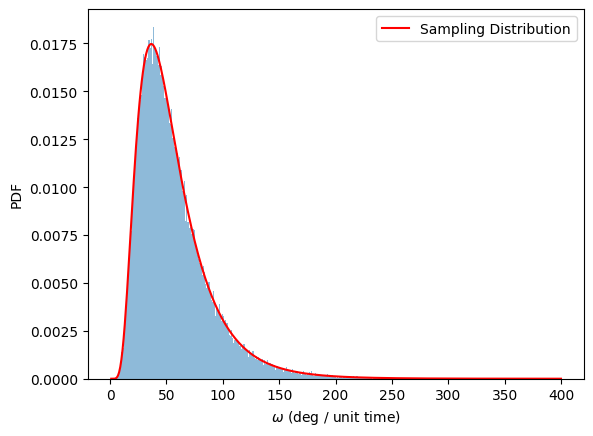

In [8]:
# Velocity Distributions
nonzero_vels = jnp.abs(velocities.flatten()[actions.flatten() != 0])
def lognormal(x, mu, sigma):
    return np.exp(-(np.log(x) - mu)**2 / (2 * sigma**2)) / (x * sigma * (2 * np.pi)**0.5)
plt.hist(nonzero_vels, bins=np.linspace(0,400,400), alpha=0.5, density=True)
plt.plot(np.linspace(1,400, 399), lognormal(np.linspace(1, 400, 399), 3.89, 0.54), color='r', label='Sampling Distribution')
plt.legend()
plt.ylabel('PDF')
plt.xlabel('$\omega$ (deg / unit time)');

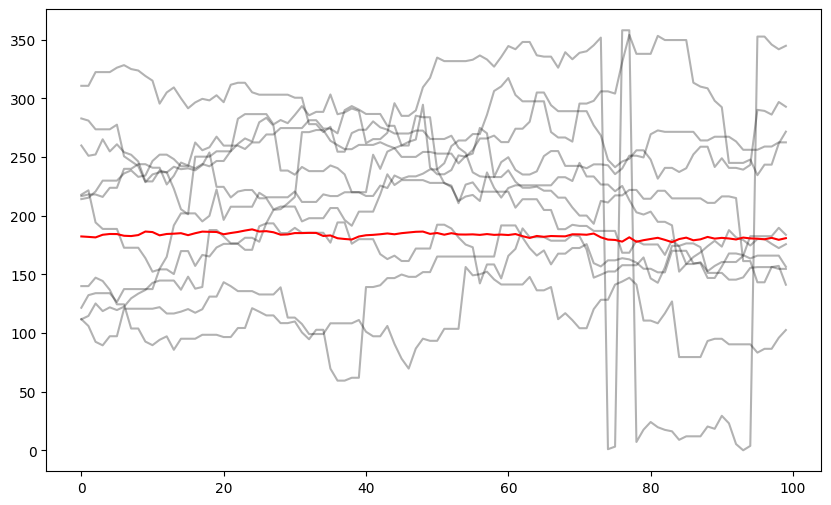

In [9]:
# Trajectories 
idx = 666
fig, ax = plt.subplots(figsize=(10,6))
for traj in angles[idx:idx+10]:
    ax.plot(traj % 360, alpha=0.3, color='k')
ax.plot(jnp.mean((angles % 360), axis=0), color='r', label='average trajectory'); 
    

In [10]:
# Converting angles to one hot representations and adding an offset
one_hot_angles = jnp.pad(vmap(to_1_hot)(trajectories[0]), ((0,0), (0,0), (0,1)), mode='constant', constant_values=1.0) 
one_hot_goals = jnp.pad(vmap(to_1_hot)(goals), ((0,0), (0,1)), mode='constant', constant_values=1.0)
one_hot_angles.shape, one_hot_goals.shape

((1000, 100, 97), (1000, 97))

In [11]:
# Sample like and dislike pairs 
n_samples = 300000
sample_keys = jax.random.split(batch_keys[-1], n_samples)
raw_state_triplets, index_triplets = vmap(
    sample_trajectory, in_axes=(0, None, None, None, None))(sample_keys, one_hot_angles, actions, tau_saccade, tau_fixation)
[(x.shape, y.shape) for x, y in zip(raw_state_triplets, index_triplets)]

[((300000, 97), (300000,)),
 ((300000, 97), (300000,)),
 ((300000, 97), (300000,))]

In [39]:
# Converting indices
anchor_traj_idxs, anchor_idxs = index_triplets[0] // horizon, index_triplets[0] % horizon
like_traj_idxs, like_idxs = index_triplets[1] // horizon, index_triplets[1] % horizon
dislike_traj_idxs, dislike_idxs = index_triplets[2] // horizon, index_triplets[2] % horizon 
# Separating by actions taken at each anchor state 
anchor_f_idxs = anchor_idxs[actions[anchor_traj_idxs, anchor_idxs] == 0]
anchor_ls_idxs = anchor_idxs[actions[anchor_traj_idxs, anchor_idxs] == 1]
anchor_rs_idxs = anchor_idxs[actions[anchor_traj_idxs, anchor_idxs] == 2]
# Finding corresponding like idxs 
like_f_idxs = like_idxs[actions[anchor_traj_idxs, anchor_idxs] == 0]
like_ls_idxs = like_idxs[actions[anchor_traj_idxs, anchor_idxs] == 1]
like_rs_idxs = like_idxs[actions[anchor_traj_idxs, anchor_idxs] == 2]


In [29]:
# FIXXX THIS
a = anchor_traj_idxs - dislike_traj_idxs
anchor_traj_idxs[69262], dislike_traj_idxs[69262]

(Array(0, dtype=int32), Array(0, dtype=int32))

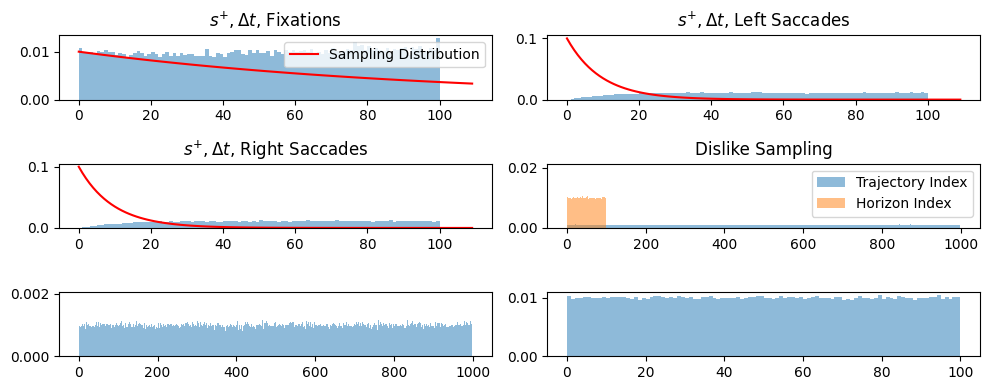

In [77]:
# Histogram of index distances for saccades vs fixations, like and dislike
fig, axs = plt.subplots(3, 2, figsize=(10, 4), tight_layout=True)
# Plot of trajectory for like, plot of index for like 
axs[0,0].hist(like_f_idxs - anchor_f_idxs, bins=np.arange(horizon+10), density=True, alpha=0.5)
axs[0,0].plot(tau_fixation * (1 - tau_fixation)**(np.arange(horizon+10)), color='r', label='Sampling Distribution')
axs[0,0].set_title("$s^{+}, \Delta t$, Fixations")
axs[0,0].legend()
axs[0,1].hist(like_ls_idxs - anchor_ls_idxs, bins=np.arange(horizon+10), density=True, alpha=0.5)
axs[0,1].plot(tau_saccade * (1 - tau_saccade)**(np.arange(horizon+10)), color='r', label='Sampling Distribution')
axs[0,1].set_title("$s^{+}, \Delta t$, Left Saccades")
axs[1,0].hist(like_rs_idxs - anchor_rs_idxs, bins=np.arange(horizon+10), density=True, alpha=0.5)
axs[1,0].plot(tau_saccade * (1 - tau_saccade)**(np.arange(horizon+10)), color='r', label='Sampling Distribution')
axs[1,0].set_title("$s^{+}, \Delta t$, Right Saccades")
axs[1,1].hist(dislike_traj_idxs, bins=np.arange(n_trajectories), alpha=0.5, label="Trajectory Index", density=True)
axs[1,1].hist(dislike_idxs, bins=np.arange(horizon), alpha=0.5, label="Horizon Index", density=True)
axs[1,1].set_title("Dislike Sampling")
axs[1,1].legend()
axs[2,0].hist(anchor_traj_idxs, bins=np.arange(n_trajectories), alpha=0.5, density=True)
axs[2,1].hist(anchor_idxs, bins=np.arange(horizon+1), alpha=0.5, density=True);
# axs[0,0].plot(tau_fixation * tau_fixation**(np.arange(horizon)), color='r', label='Sampling Distribution')
# axs[0,1].hist(anchor_traj_idxs, bins=np.arange(n_trajectories), density=True, alpha=0.5)
# axs[0,1].hist(like_traj_idxs, bins=np.arange(n_trajectories), density=True, alpha=1.0)
# # Plot of trajectory for dislike, plot if index for dislike 
# axs[1,0].hist(dislike_idxs, bins=np.arange(horizon), density=True, alpha=0.5)
# axs[1,1].hist(anchor_traj_idxs - dislike_traj_idxs, density=True)

(0.0, 0.02)

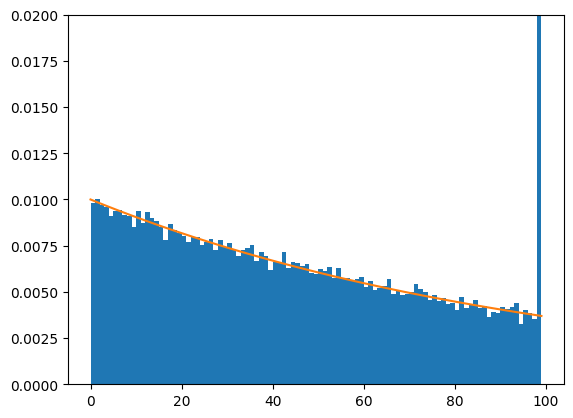

In [66]:
plt.hist(like_f_idxs, bins=np.arange(horizon), density=True)
plt.plot(tau_fixation * (1 - tau_fixation)**np.arange(horizon))
plt.ylim([0,0.02])

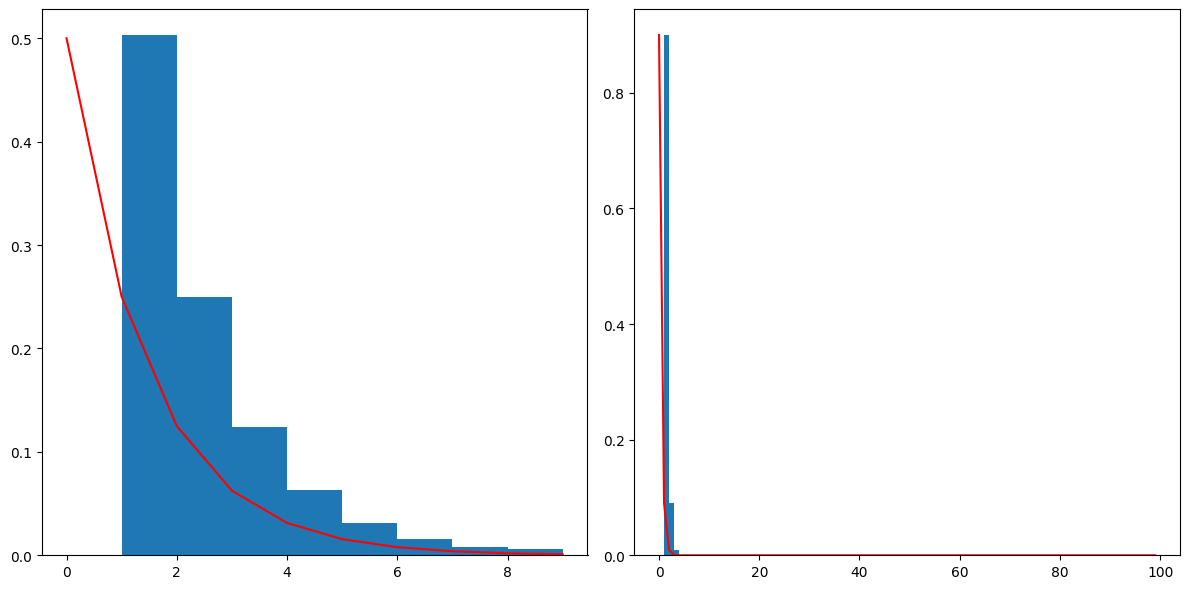

In [139]:
def sample_like_proto(
    sample_key: jax.Array, action: int, state_index: int, tau_s: float, tau_f: float
):
    """
    Samples the next state from a trajectory based on the current action and state index.

    Args:
        sample_key (jax.Array): Random key for sampling.
        trajectory (ArrayLike): The trajectory from which to sample the next state.
        action (int): The current action taken.
        state_index (int): The current index of the state in the trajectory.
        tau_s (float): Probability parameter for sampling time lag given a saccade.
        tau_f (float): Probability parameter for sampling time lag given a fixation.

    Returns:
        Tuple[ArrayLike, int]: A tuple containing the sampled state and its corresponding index.
    """
    # Recognize previous action
    is_fixated = action == 0
    # Sample time lag
    time_step = jax.lax.cond(
        is_fixated,
        lambda k: jax.random.geometric(k, p=tau_f),
        lambda k: jax.random.geometric(k, p=tau_s),
        sample_key,
    )
    # Sample next state
    next_index = jnp.max(jnp.array([horizon - 1, state_index + time_step]))
    return time_step, next_index

n_ex = 100000
ex_actions = actions[anchor_traj_idxs, anchor_idxs]
ex_af = ex_actions[ex_actions == 0][:n_ex]
ex_as = ex_actions[ex_actions != 0][:n_ex]

ex_keys = jax.random.split(jax.random.PRNGKey(0xf), n_ex)
ex_state_idxs = anchor_idxs[:n_ex]

fig, axs = plt.subplots(1,2, figsize=(12,6), tight_layout=True)
ex_lags_f, ex_idxs_f = vmap(sample_like_proto, in_axes=(0, 0, 0, None, None))(ex_keys, ex_af, ex_state_idxs, tau_saccade, tau_fixation)
ex_lags_s, ex_idxs_s = vmap(sample_like_proto, in_axes=(0, 0, 0, None, None))(ex_keys, ex_as, ex_state_idxs, tau_saccade, tau_fixation)
axs[0].hist(ex_lags_f, bins=np.arange(horizon//10), density=True)
axs[0].plot(tau_fixation * (1 - tau_fixation)**(np.arange(horizon//10)), color='r')
axs[1].hist(ex_lags_s, bins=np.arange(horizon), density=True)
axs[1].plot(tau_saccade * (1 - tau_saccade)**(np.arange(horizon)), color='r');


In [136]:
ex_idxs_f

Array([99, 99, 99, ..., 99, 99, 99], dtype=int32)

In [ ]:
# visualize successor here - perhaps sinusoidal
# run some unit tests on the sampling code

In [63]:
# Get actions for each anchor state
anchor_batch_idxs = index_triplets[0] // horizon
anchor_idxs = index_triplets[0] % horizon
anchor_actions = actions[anchor_batch_idxs, anchor_idxs]
# Initialize container variable - include new axis for different actions
extended_anchor_states = np.zeros((raw_state_triplets[0].shape[0], n_actions, raw_state_triplets[0].shape[1]))
# Populate with correct anchor state at selected action
extended_anchor_states[np.arange(n_samples), anchor_actions] = raw_state_triplets[0]
# Flatten over actions 
extended_anchor_states = jnp.reshape(extended_anchor_states, (n_samples, -1))
state_triplets = raw_state_triplets.copy()
state_triplets[0] = extended_anchor_states
[x.shape for x in state_triplets]


[(300000, 291), (300000, 97), (300000, 97)]

In [70]:
# Splitting data into train / val / test
train_ratio = 0.8
train_index = int(n_samples * train_ratio)

train_set = [x[:train_index] for x in state_triplets]
val_set = [x[train_index:] for x in state_triplets]

# Collate data into minibatches
batched_train = [jnp.reshape(x, (x.shape[0] // minibatch_size, minibatch_size, -1)) for x in train_set]
[x.shape for x in batched_train]

[(240, 1000, 291), (240, 1000, 97), (240, 1000, 97)]

# Optimization

In [71]:
var_keys = jax.random.split(sample_keys[-1], 2)

# (rep_dim, input_dim x n_actions)
phi = jax.random.normal(key=var_keys[0], shape=(rep_dim, train_set[0].shape[-1])) 
# (rep dim, input_dim)
psi = jax.random.normal(key=var_keys[1], shape=(rep_dim, train_set[1].shape[-1]))

# Column normalize  
phi_norms = jnp.linalg.norm(phi, axis=0, keepdims=True)
psi_norms = jnp.linalg.norm(psi, axis=0, keepdims=True)
phi /= phi_norms 
psi /= psi_norms 
print(jnp.linalg.norm(phi, axis=0).sum(), jnp.linalg.norm(psi, axis=0).sum())

params = {'phi': phi, 'psi': psi}

# Creating the optimizer 
lr = 0.0001
optimizer = optax.adam(learning_rate=lr)
opt_state = optimizer.init(params)


291.0 97.0


In [72]:
# Training step 
@jit
def train_step(params: optax.Params, opt_state: Tuple , batch: List[ArrayLike]) -> Tuple[optax.Params, Tuple, float]:
    """_summary_

    Args:
        params (optax.Params): Parameters to optimize
        opt_state (Tuple): Current optimizer state 
        batch (List[ArrayLike]): (Anchor states, like_states, dislike_states)
        loss_fn (Callable): Loss function with call signature f(params, *batch)

    Returns:
        Tuple[optax.Params, Tuple, float]: new params, opt_state, loss over minibatch
    """
    loss, grads = jax.value_and_grad(contrastive_loss)(params, *batch)
    updates, opt_state = optimizer.update(grads, opt_state, params)
    params = optax.apply_updates(params, updates)
    return params, opt_state, loss
    

In [73]:
n_epochs = 1000
tol = 1e-6
current_loss = float('inf')
loss_history = []
val_loss_history = []
param_history = []
n_batches = batched_train[0].shape[0]
prog_bar = tqdm(range(n_epochs), desc="Epochs")
for epoch in prog_bar:
    for i in range(n_batches):
        minibatch = [x[i] for x in batched_train]
        params, opt_state, loss = train_step(params, opt_state, minibatch)
    
    val_loss_history.append(contrastive_loss(params, *val_set))
    prog_bar.set_postfix(loss=loss, val_loss=val_loss_history[epoch])
    
    loss_history.append(loss)
    param_history.append(params)
    if jnp.abs(loss - current_loss) < tol: break
    current_loss = loss

Epochs:  44%|████▍     | 883/2000 [05:22<06:47,  2.74it/s, loss=1.1186024, val_loss=1.1271741]


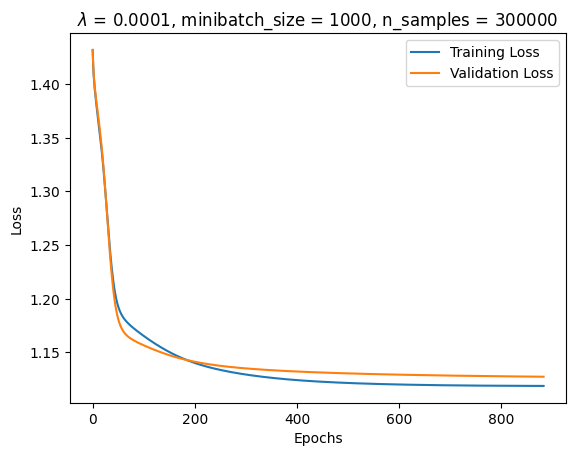

In [74]:
plt.plot(loss_history, label='Training Loss')
plt.plot(val_loss_history, label='Validation Loss')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title(f'$\lambda$ = {lr}, minibatch_size = {minibatch_size}, n_samples = {n_samples}')
plt.legend();
plt.savefig(f"viz/loss_plot_{lr}_{minibatch_size}_{n_samples}.png", format='png', dpi='figure')

# Visualizing Representations

In [88]:
fixate_phi, left_phi, right_phi = jnp.split(params['phi'], n_actions, axis=1)
psi = params['psi']
fixate_phi.shape, left_phi.shape, right_phi.shape, psi.shape

((16, 97), (16, 97), (16, 97), (16, 97))

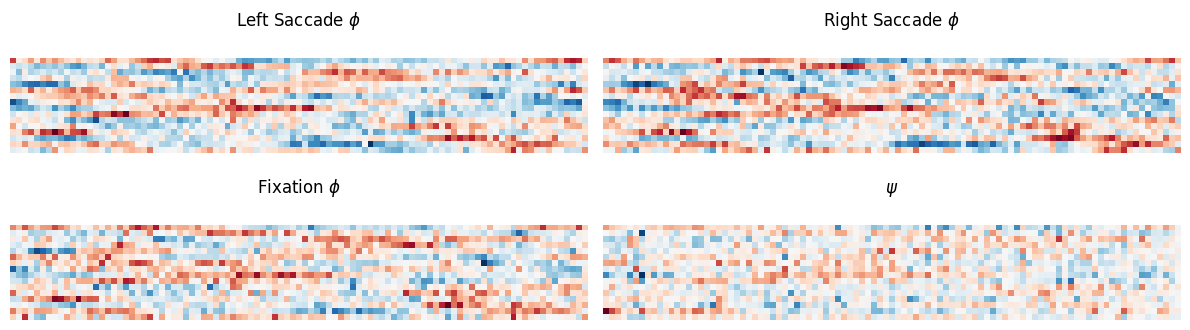

In [107]:
fig, axs = plt.subplots(2, 2, figsize=(12,4), tight_layout=True)
axs[0,0].matshow(left_phi, cmap='RdBu')
axs[0,0].set_title('Left Saccade $\phi$')
axs[0,0].set_axis_off()
axs[0,1].matshow(right_phi, cmap='RdBu')
axs[0,1].set_title('Right Saccade $\phi$')
axs[0,1].set_axis_off()
axs[1,0].matshow(fixate_phi, cmap='RdBu')
axs[1,0].set_title('Fixation $\phi$')
axs[1,0].set_axis_off()
axs[1,1].matshow(psi, cmap='RdBu')
axs[1,1].set_title('$\psi$')
axs[1,1].set_axis_off()
plt.savefig('viz/representations.png', format='png', dpi='figure')

In [84]:
# look at psi first, apply some non-negativity constraint to enforce uniqueness 
# Figure out a pipeline to generate this quickly 
# Explore ranges of gammas (sampling interval)
# Shouldn't see anything as gamma -> \inf 
# Add some constraints to the matrices 
# Visualize what the successor matrix looks like 
# s x s' x a (state t steps later, t samples from gemoetric distribution)

Signature: np.repeat(a, repeats, axis=None)
Docstring:
Repeat elements of an array.

Parameters
----------
a : array_like
    Input array.
repeats : int or array of ints
    The number of repetitions for each element.  `repeats` is broadcasted
    to fit the shape of the given axis.
axis : int, optional
    The axis along which to repeat values.  By default, use the
    flattened input array, and return a flat output array.

Returns
-------
repeated_array : ndarray
    Output array which has the same shape as `a`, except along
    the given axis.

See Also
--------
tile : Tile an array.
unique : Find the unique elements of an array.

Examples
--------
>>> np.repeat(3, 4)
array([3, 3, 3, 3])
>>> x = np.array([[1,2],[3,4]])
>>> np.repeat(x, 2)
array([1, 1, 2, 2, 3, 3, 4, 4])
>>> np.repeat(x, 3, axis=1)
array([[1, 1, 1, 2, 2, 2],
       [3, 3, 3, 4, 4, 4]])
>>> np.repeat(x, [1, 2], axis=0)
array([[1, 2],
       [3, 4],
       [3, 4]])
File:      ~/mambaforge3/envs/jax_0.4/lib/python3.9/si